In [358]:
import sys
#sys.path.append('/Users/joseivan/Desktop/Py/pyFlowmaps1.0/MainCodes/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
import h5py
import sunpy.map as smap
import glob
from astropy.modeling import models, fitting
import warnings
warnings.filterwarnings("ignore")
import hazel
label = ['I', 'Q', 'U', 'V']
#from math_tools import smooth
from scipy.ndimage import gaussian_filter
import os
import imageio as io
import pandas as pd


In [359]:
#Orginal submpas normalization ycont2_m = 59125.408672799305
#ycont2_m = 59125.408672799305


# Index

1. Read submap folder

    1.1 Read Atm submaps
    
2. Stokes data obtention

    2.1 Atm Stokes data obtention
    
3. Quiet Sun point for Stokes normalization

4. Mean of the region for normalization and Voigt 1D function

5. LevMarLSQFitter for Voigt 1D

6. Normalization factor, max value V2 + max value mean normalization region

7. Saving wavelength file and 1d observations

8. One pixel test inversion

9. 3D data preparation

# Functions

In [360]:
def stokes_plot(stokes_i,stokes_q,stokes_u,stokes_v):
    stokes = np.zeros([6,4,nx,ny])
    stokes[:,0,:,:] = stokes_i
    stokes[:,1,:,:] = stokes_q
    stokes[:,2,:,:] = stokes_u
    stokes[:,3,:,:] = stokes_v
    names = ['Stokes I','Stokes Q','Stokes U','Stokes V']
    fig = plt.figure(figsize=(24,10))
    for i in range(4):
        ax = fig.add_subplot(2,4,i+1)
        ax.set_title(names[i],fontsize=25)
        im = ax.imshow(stokes[0,i,:,:],cmap = 'YlOrBr_r')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')


# 1. Read Submap folder

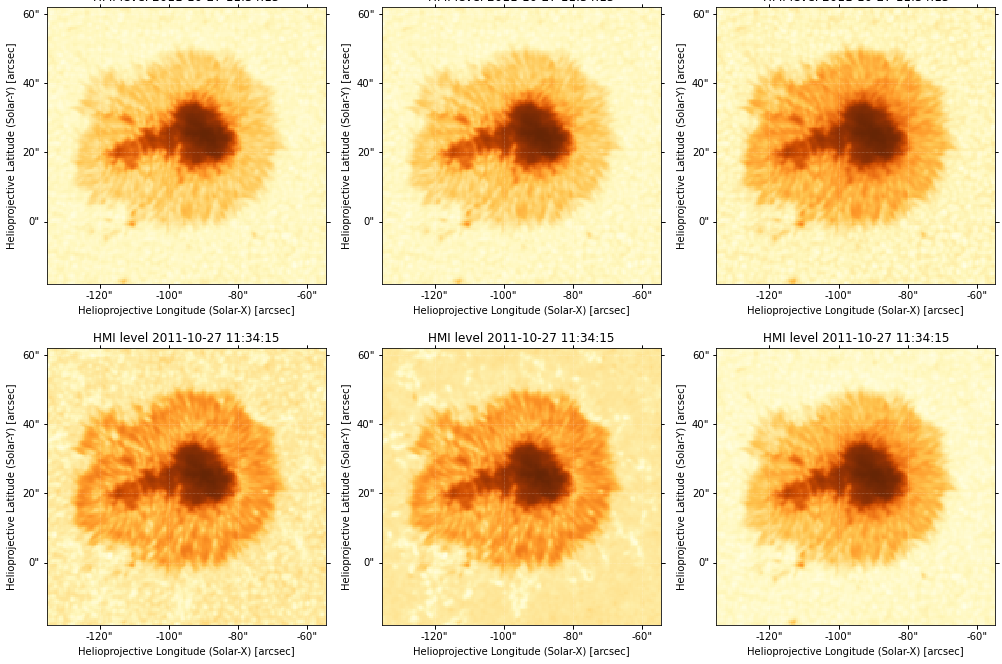

In [361]:


#Using jose ivan previous sunspot maps
#folder_in = '/home/miguel/Solar-physics-project/Proyecto Avanzado 2/Hazel practice/JoseIvan sin modificar/SubmapsStokes/'
#files_I = sorted(glob.glob(folder_in+'submap.S_720s.20111027_180000_TAI.1.I*.fits'))

sunspot_date = '20111027_113600'
sunspot_date1 = '2011-10-27T11:30:00'

folder_in = '/home/miguel/Solar-physics-project/Thesis/stokes_data/sub_stokes_'+sunspot_date1+'/'
maps = 'submap.hmi.s_720s.'+sunspot_date+'_TAI.1.'
files_I = sorted(glob.glob(folder_in+maps+'I*.fits'))
files_Q = sorted(glob.glob(folder_in+maps+'Q*.fits'))
files_U = sorted(glob.glob(folder_in+maps+'U*.fits'))
files_V = sorted(glob.glob(folder_in+maps+'V*.fits'))

#print(files_I)
fig = plt.figure(figsize=(17,11.5))
for i in range(1,7):
    xmap = smap.Map(files_I[i-1])
    xmap.plot_settings['cmap'] = plt.cm.YlOrBr_r
    ax = fig.add_subplot(2,3,i, projection=xmap)
    xmap.plot()
 

In [362]:
#adjusting date name for the observations file
gn1=103
gn2=118
print(files_Q[0][gn1:gn2])

20111027_113600


# 1.1 Read Atm submaps

# 2. Stokes data obtention

In [363]:
#Stokes data obtantion 
nx = len(fits.getdata(files_I[0])) #number of pixels in x
ny = len(fits.getdata(files_I[0])[0]) #numver of pixels in y

print(nx)
print(ny)

stokes_i = np.zeros([6,nx,ny])
stokes_q = np.zeros([6,nx,ny])
stokes_u = np.zeros([6,nx,ny])
stokes_v = np.zeros([6,nx,ny])

for i in range(6):
    stokes_i[i,:,:] = fits.getdata(files_I[5-i])
    stokes_q[i,:,:] = fits.getdata(files_Q[5-i])
    stokes_u[i,:,:] = fits.getdata(files_U[5-i])
    stokes_v[i,:,:] = fits.getdata(files_V[5-i])

159
160


# 2.1 Atm Stokes data obtention

# 3. Quiet Sun point for Stokes normalization

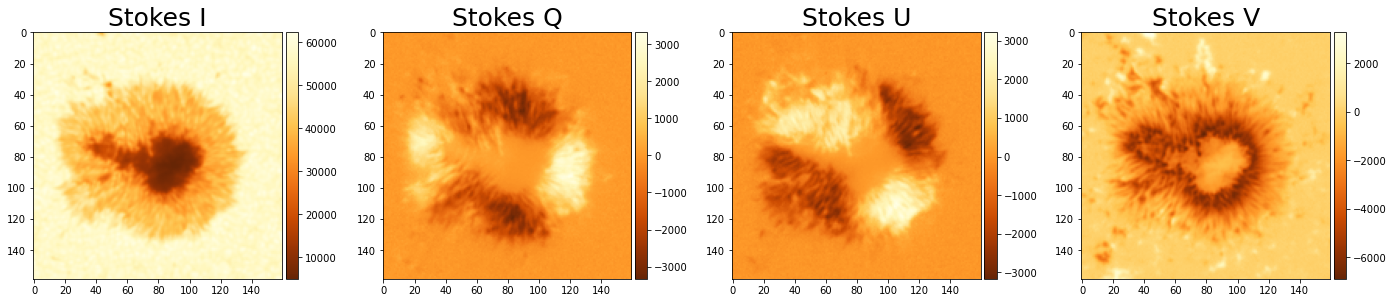

In [364]:
stokes_plot(stokes_i,stokes_q,stokes_u,stokes_v)

## submap reduced 

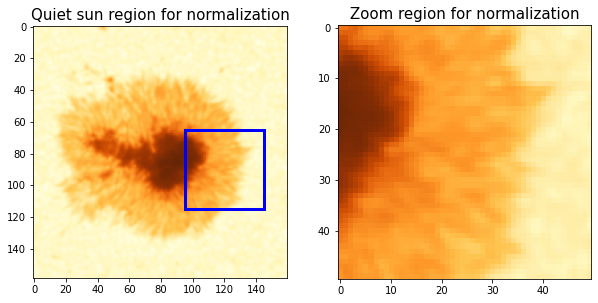

In [236]:
rect_new_size = 50

pos_x = 120
pos_y = 90

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
ax[0].imshow(stokes_i[0,:,:],cmap = 'YlOrBr_r')
ax[0].set_title('Quiet sun region for normalization',fontsize=15)
x_new = int(pos_y-rect_new_size/2)
y_new = int(pos_x-rect_new_size/2)

rect_new = patches.Rectangle((y_new,x_new), rect_new_size,rect_new_size, linewidth=3, edgecolor='b', facecolor='none')
#rectangle coordinates are (x,y) positons, and for the Jose Ivan code, the region was chosen as stokes_i[1,0:20,-20:]
#where 1 wavelength was selected, 0:20 means first 20 rows were selected, and -20: means 218 to 238 colums where selected
# rectangle position (218,20) is the same as stokes_i[1,0:20,-20:], 216 was chosen instead of 218 so the contour can be seen properly,
#but the region selected for normalization is 218 to 238 columns (a 20x20 square)
ax[0].add_patch(rect_new)
ax[1].imshow(stokes_i[0,x_new:x_new+rect_new_size,y_new:y_new+rect_new_size],cmap = 'YlOrBr_r',vmin=np.min(stokes_i),vmax=np.max(stokes_i))
ax[1].set_title('Zoom region for normalization',fontsize=15)

plt.show()

In [237]:
stokes_i = stokes_i[:,x_new:x_new+rect_new_size,y_new:y_new+rect_new_size]
stokes_q = stokes_q[:,x_new:x_new+rect_new_size,y_new:y_new+rect_new_size]
stokes_u = stokes_u[:,x_new:x_new+rect_new_size,y_new:y_new+rect_new_size]
stokes_v = stokes_v[:,x_new:x_new+rect_new_size,y_new:y_new+rect_new_size]

nx = stokes_i[0,:,:].shape[0]
ny = stokes_i[0,:,:].shape[1]

## normal submaps

Text(0.5, 1.0, 'Stokes V')

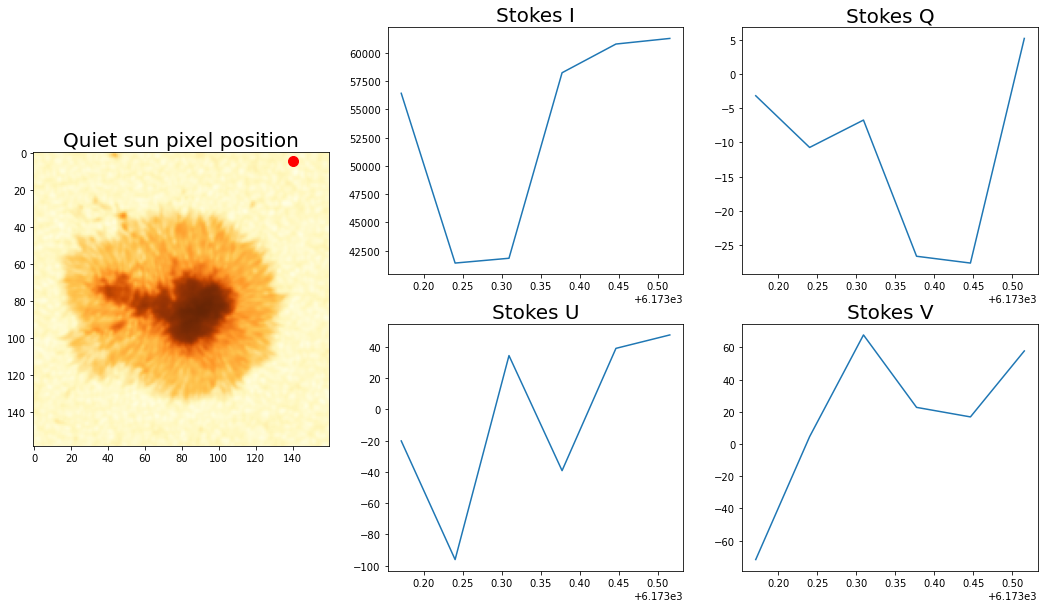

In [365]:
#wavelengths vector (SDO 6 uses only 6 points)
wl0 = 6173.3433
dlambda = np.array([-0.172,-0.103,-0.034,0.034,0.103,0.172])

quiet_nx = 140
quiet_ny = 4

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,5)
ax5 = fig.add_subplot(2,3,6)

ax1.imshow(stokes_i[0,:,:],cmap = 'YlOrBr_r')

ax1.set_title('Quiet sun pixel position', fontsize = 20)
ax1.scatter([quiet_nx], [quiet_ny], color='red', s=100)
#remember that (x,y) coordinates are (y,x) rows and colums selection
ax2.plot(dlambda + wl0, stokes_i[:,quiet_ny,quiet_nx])
ax2.set_title('Stokes I', fontsize = 20)
ax3.plot(dlambda + wl0, stokes_q[:,quiet_ny,quiet_nx])
ax3.set_title('Stokes Q', fontsize = 20)
ax4.plot(dlambda + wl0, stokes_u[:,quiet_ny,quiet_nx])
ax4.set_title('Stokes U', fontsize = 20)
ax5.plot(dlambda + wl0, stokes_v[:,quiet_ny,quiet_nx])
ax5.set_title('Stokes V', fontsize = 20)

4 140


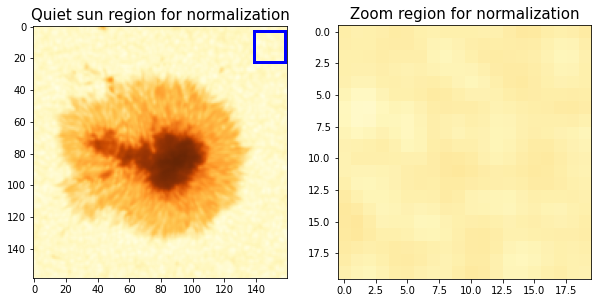

In [366]:
#quiet sun normalization, selecting a portion of the quiet sun around the sunspot of interest
rect_quiet_sun_size = 20

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
ax[0].imshow(stokes_i[0,:,:],cmap = 'YlOrBr_r')
ax[0].set_title('Quiet sun region for normalization',fontsize=15)
print(quiet_ny,quiet_nx)
x = quiet_ny-3/2
y = quiet_nx-3/2

rect = patches.Rectangle((y,x), rect_quiet_sun_size,rect_quiet_sun_size, linewidth=3, edgecolor='b', facecolor='none')
#rectangle coordinates are (x,y) positons, and for the Jose Ivan code, the region was chosen as stokes_i[1,0:20,-20:]
#where 1 wavelength was selected, 0:20 means first 20 rows were selected, and -20: means 218 to 238 colums where selected
# rectangle position (218,20) is the same as stokes_i[1,0:20,-20:], 216 was chosen instead of 218 so the contour can be seen properly,
#but the region selected for normalization is 218 to 238 columns (a 20x20 square)
ax[0].add_patch(rect)
ax[1].imshow(stokes_i[0,quiet_ny:quiet_ny+rect_quiet_sun_size,quiet_nx:quiet_nx+rect_quiet_sun_size],cmap = 'YlOrBr_r',vmin=np.min(stokes_i),vmax=np.max(stokes_i))
ax[1].set_title('Zoom region for normalization',fontsize=15)

plt.show()




# 4. Mean of the region for normalization and Voigt 1D function

Selected region is stokes_i[ 4 : 24 , 140 : 160 ]
Mean of the selected region in 6 wavelength points [57233.55628906 41464.99367188 42167.75245117 58768.41904297
 61219.85636719 61669.89394531]
[-0.172 -0.103 -0.034  0.034  0.103  0.172]


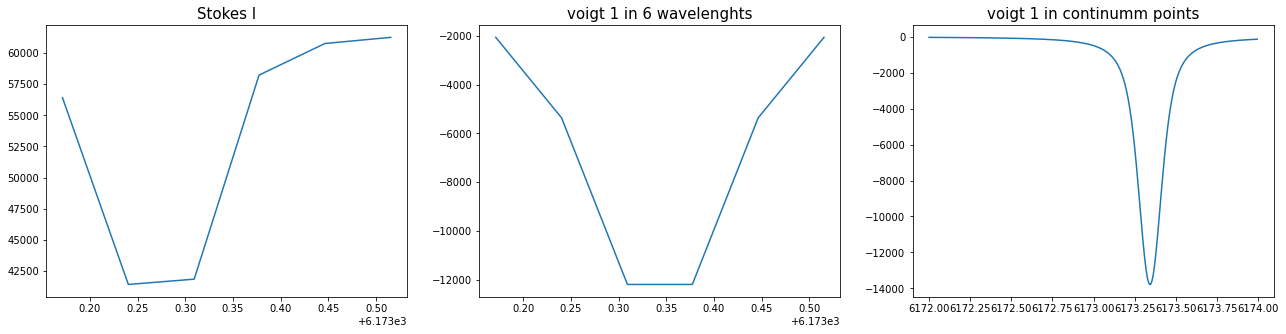

In [367]:
i_cont = np.mean(stokes_i[:,quiet_ny:quiet_ny+rect_quiet_sun_size,quiet_nx:quiet_nx+rect_quiet_sun_size],axis=(1,2))
print('Selected region is stokes_i[',quiet_ny,':',quiet_ny+rect_quiet_sun_size,',',quiet_nx,':',quiet_nx+rect_quiet_sun_size, ']')
print('Mean of the selected region in 6 wavelength points', i_cont)
v1 = models.Voigt1D(x_0=wl0,amplitude_L=-18800,fwhm_L=0.11, fwhm_G=0.1)
xfull = np.arange(6172,6174,0.005)


fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(131)
ax1.plot(dlambda + wl0,stokes_i[:,quiet_ny,quiet_nx])
ax1.set_title('Stokes I',fontsize=15)

ax2 = fig.add_subplot(132)
ax2.plot(dlambda + wl0, v1(dlambda + wl0))
ax2.set_title('voigt 1 in 6 wavelenghts',fontsize=15)

ax3 = fig.add_subplot(133)
ax3.set_title('voigt 1 in continumm points',fontsize=15)
ax3.plot(xfull, v1(xfull))

print(dlambda)

# 5. LevMarLSQFitter for Voigt 1D to get V2

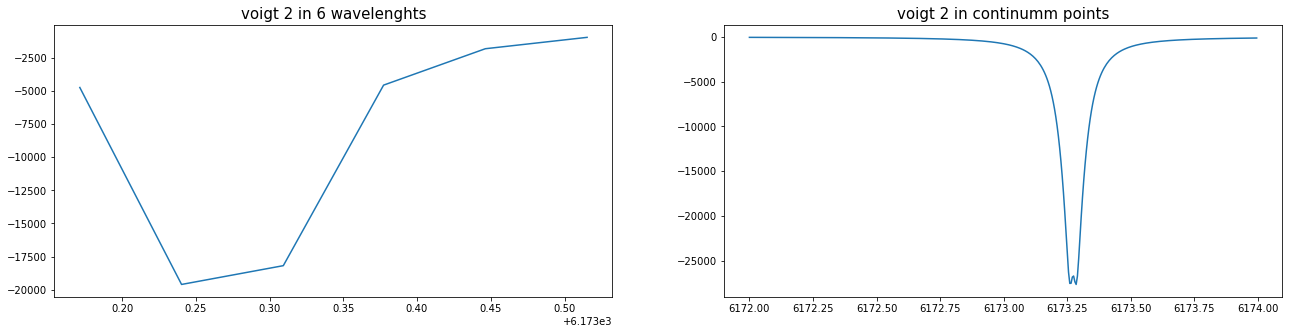

In [368]:
fit_t = fitting.LevMarLSQFitter()
v2 = fit_t(v1,dlambda + wl0,i_cont-np.max(i_cont))

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(121)
ax1.set_title('voigt 2 in 6 wavelenghts',fontsize=15)
ax2 = fig.add_subplot(122)
ax2.set_title('voigt 2 in continumm points',fontsize=15)
ax1.plot(dlambda + wl0, v2(dlambda + wl0))
ax2.plot(xfull, v2(xfull))

# 6. Normalization factor, max value V2 + max value mean normalization region

60720.519019675354


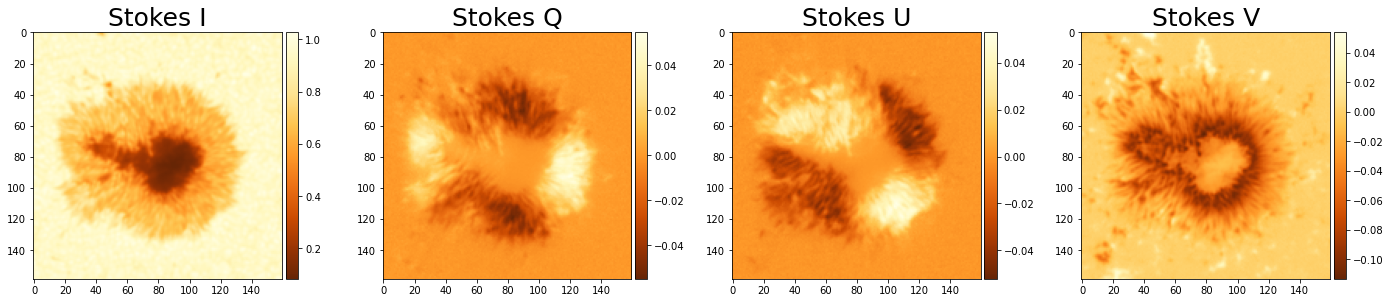

In [369]:
ycont2_m = np.max(v2(dlambda + wl0))+np.max(i_cont)
print(ycont2_m)
#ycont2_m = 59125.408672799305
stokes_i = stokes_i/ycont2_m
stokes_q = stokes_q/ycont2_m
stokes_u = stokes_u/ycont2_m
stokes_v = stokes_v/ycont2_m

stokes_plot(stokes_i,stokes_q,stokes_u,stokes_v)

Text(0.5, 1.0, 'Stokes V normalized')

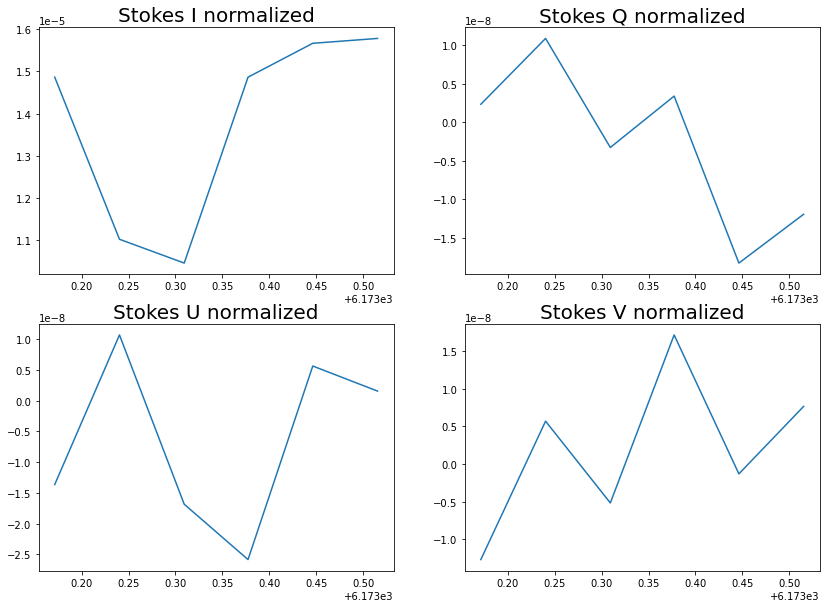

In [357]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
ax[0,0].plot(dlambda + wl0, stokes_i[:,20,-20])
ax[0,0].set_title('Stokes I normalized', fontsize = 20)
ax[0,1].plot(dlambda + wl0, stokes_q[:,20,-20])
ax[0,1].set_title('Stokes Q normalized', fontsize = 20)
ax[1,0].plot(dlambda + wl0, stokes_u[:,20,-20])
ax[1,0].set_title('Stokes U normalized', fontsize = 20)
ax[1,1].plot(dlambda + wl0, stokes_v[:,20,-20])
ax[1,1].set_title('Stokes V normalized', fontsize = 20)

# 7. Saving wavelength file and 1d observations

In [276]:
np.savetxt('/home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi.wavelength', dlambda + wl0, header='lambda')

In [277]:
stokes = np.zeros([6,nx,ny,4])
stokes[:,:,:,0] = stokes_i
stokes[:,:,:,1] = stokes_q
stokes[:,:,:,2] = stokes_u
stokes[:,:,:,3] = stokes_v
stokes.shape
#plt.plot(,stokes[:,0,0,0])
#preparing single pixel
stk = np.zeros([4,6])

#asign new values to invert different regions of the sun
#quiet_ny = 205
#quiet_nx = 145
stk[0,:] = stokes[:,quiet_ny,quiet_nx,0]
stk[1,:] = stokes[:,quiet_ny,quiet_nx,1]
stk[2,:] = stokes[:,quiet_ny,quiet_nx,2]
stk[3,:] = stokes[:,quiet_ny,quiet_nx,3]
noise = np.zeros((6,4))
noise[:,0] = 0.0118*np.ones(6) # original noise values 0.118
noise[:,1] = 0.0204*np.ones(6) # 0.204
noise[:,2] = 0.0204*np.ones(6) # 0.204
noise[:,3] = 0.0204*np.ones(6) # 0.204

In [278]:
tmp = hazel.tools.File_observation(mode='single')
tmp.set_size(n_lambda=6, n_pixel=1)
print(tmp.obs['stokes'].shape)
tmp.obs['wavelength'] = dlambda + wl0    # The wavelength in the file is given wrt the blue component but this is wrong
tmp.obs['stokes'][0,:,:] = stk.T
tmp.obs['sigma'] = noise
tmp.obs['los'][0,:] = np.array([0.0,0.0,90.0])
tmp.obs['boundary'][:] = 0.0
tmp.obs['boundary'][0,:,0] = 1.0
tmp.obs['weights'][:] = 1.0
tmp.save('/home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi')
#tmp.save('/home/miguel/Solar-physics-project/Proyecto Avanzado 2/Hazel practice/organized/inversions/observations/6173_atm_r0_cm_'+str(r0_cm)+'_hmi') #6173_atm_r0_cm_1_hmi.1d
#tmp.save('/home/miguel/Solar-physics-project/Proyecto Avanzado 2/Hazel practice/organized/inversions/observations/6173_atm_r0_cm_'+str(r0_cm)+'_hmi')

(1, 6, 4)
Saving wavelength file : /home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi.wavelength
Saving weights file : /home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi.weights
Saving 1D Stokes file : /home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi.1d


In [279]:
#init_spot no es el mismo que hmi_model

tmp = hazel.tools.File_photosphere(mode='single')
tmp.set_default(n_pixel=1, default='hsra')
tmp.save('/home/miguel/Solar-physics-project/Thesis/inversions/photospheres/hsra_spot')

Setting photosphere to model hsra
Saving photospheric 1D model : /home/miguel/Solar-physics-project/Thesis/inversions/photospheres/hsra_spot.1d


# 8. One pixel test inversion

In [280]:
#os.remove('/home/miguel/Solar-physics-project/Thesis/inversions/outputs/output_1d.h5') 
mod = hazel.Model('/home/miguel/Solar-physics-project/Thesis/inversions/conf_hmi_1d.ini', 
                  working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2024-02-10 10:43:57,209 - Hazel2 v1.0
2024-02-10 10:43:57,210 - Using configuration from file : /home/miguel/Solar-physics-project/Thesis/inversions/conf_hmi_1d.ini
2024-02-10 10:43:57,212 - Backtracking mode : brent
2024-02-10 10:43:57,212 - Adding spectral region spec1
2024-02-10 10:43:57,213 -   - Using wavelength axis from 6173.15 to 6173.55 with 6 steps
2024-02-10 10:43:57,213 -   - Reading wavelength axis from /home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi.wavelength
2024-02-10 10:43:57,215 -   - Setting all wavelength weights to 1
2024-02-10 10:43:57,215 -   - Using observations from /home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi.1d
2024-02-10 10:43:57,216 -   - No mask for pixels
2024-02-10 10:43:57,216 -   - No instrumental profile
2024-02-10 10:43:57,216 -   - Using LOS ['0.0', '0.0', '90.0']
2024-02-10 10:43:57,217 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2024-02-10 10:43:57,217 - Using 1 cycles
2024-

(npix,ncycle,nstokes,nlambda) -> (1, 1, 4, 6)


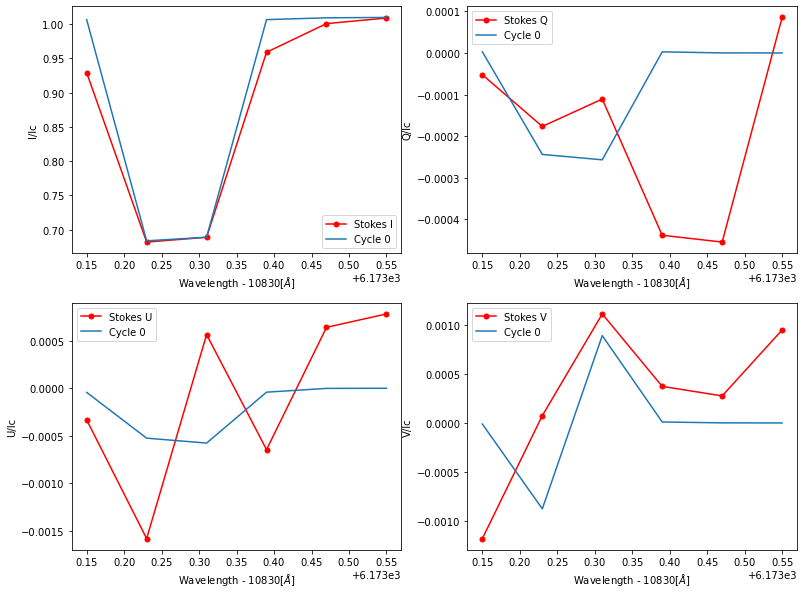

In [281]:
f = h5py.File('/home/miguel/Solar-physics-project/Thesis/inversions/outputs/output_1d.h5', 'r')

print('(npix,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:], stk[i,:],'r-o',ms=5,label='Stokes '+label[i])
    for j in range(1):
        ax[i].plot(f['spec1']['wavelength'][:], f['spec1']['stokes'][0,j,i,:],label='Cycle '+str(j))
    

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].legend()
    #ax[i].set_xlim([-7,3])

#pl.tight_layout()

f.close()

# 9. 3D data preparation

In [282]:
n_lambda=6
n_pixel = nx * ny
stokes_3d = np.zeros((n_pixel,n_lambda,4), dtype=np.float64)
sigma_3d = np.zeros((n_pixel,n_lambda,4), dtype=np.float64)
los_3d = np.zeros((n_pixel,3), dtype=np.float64)
boundary_3d = np.zeros((n_pixel,n_lambda,4), dtype=np.float64)

stokes_n = np.swapaxes(np.swapaxes(stokes,0,1),1,2).reshape(n_pixel,6,4)
stokes_n.shape

(25440, 6, 4)

In [283]:
boundary = np.array([1.0,0.0,0.0,0.0])
for i in range(n_pixel):

    stokes_3d[i,:,:] = stokes_n[i,:,:]
    sigma_3d[i,:,:] = noise[:,:]
    los_3d[i,:] = np.array([0.0,0.0,90.0])
    boundary_3d[i,:,:] = np.repeat(np.atleast_2d(boundary), n_lambda, axis=0)
    

In [284]:
#f = h5py.File('/home/miguel/Solar-physics-project/Proyecto Avanzado 2/Hazel practice/organized/inversions/observations/6173_hmi.h5', 'w')
#f = h5py.File('/home/miguel/Solar-physics-project/Proyecto Avanzado 2/Hazel practice/organized/inversions/observations/6173_atm_r0_cm_'+str(r0_cm)+'_hmi.h5', 'w')
f = h5py.File('/home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_'+sunspot_date+'_'+str(nx)+'x'+str(ny)+'.h5', 'w')
#f = h5py.File('/home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_atm_r0_cm_'+str(r0_cm)+'_'+sunspot_date+str(nx)+'x'str(ny)+'.h5', 'w')

db_stokes = f.create_dataset('stokes', stokes_3d.shape, dtype=np.float64)
db_sigma = f.create_dataset('sigma', sigma_3d.shape, dtype=np.float64)
db_los = f.create_dataset('LOS', los_3d.shape, dtype=np.float64)
db_boundary = f.create_dataset('boundary', boundary_3d.shape, dtype=np.float64)
db_stokes[:] = stokes_3d
db_sigma[:] = sigma_3d
db_los[:] = los_3d
db_boundary[:] = boundary_3d
f.close()

In [265]:
# Saving weights 
f = open('/home/miguel/Solar-physics-project/Thesis/inversions/observations/6173_hmi_5_1_1_1.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(6):
    f.write('5.0    1.0   1.0   1.0\n')
f.close()

In [33]:
#define the size of the submaps (nx*ny)
n_pixel = nx*ny

#list of available photospheric models
tmp = hazel.tools.File_photosphere(mode='single')
tmp.list_models()


        All models have been extracted from SIR (https://github.com/BasilioRuiz/SIR-code/tree/master/models)
        
        One-component quiet Sun models:

            holmu11.mod ...  Holweger H., & Muller E.A., 1974, Sol Phys. 39 19

            hsra11.mod   ...  Harvard Smithsonian Reference Atmosphere (Gingerich O.,
                            Noyes R.W., Kalkofen W., & Cuny Y., 1971. Sol. Phys. 18, 347)

            valc11.mod   ...  Vernaza J.E., Avrett E.H., & Loeser R., 1981, ApJS 45, 635

            mackkl11.mod ...  Maltby P., Avrett E.H., Carlsson M., Kjeldseth-Moe O.,
                            Kurucz R.L., & Loeser R., 1986 ApJ 306 284

            nelsoncold.mod  Nelson G. P. 1978 Sol. Phys. 60, 5

            nelsonhot.mod   Nelson G. P. 1978 Sol. Phys. 60, 5

            grevesse11.mod .. Grevesse N., Sauval A.J. 1999 A&A 347, 348
            

        Sunspot Models:

            emaltby11.mod .. (E model) Maltby P., Avrett E.H., Carlsson M., 
                   

In [34]:
#Save 1D photospheric model
tmp.set_default(n_pixel=1, default='hsra')
tmp.save('/home/miguel/Solar-physics-project/Thesis/inversions/photospheres/hrsa_photosphere')

#Save 3D photospheric model
model =np.loadtxt('/home/miguel/Solar-physics-project/Thesis/inversions/photospheres/hrsa_photosphere.1d',skiprows=4)
print(model.shape)
model_3d=np.full([n_pixel,73,8],model)
tmp = h5py.File('/home/miguel/Solar-physics-project/Thesis/inversions/photospheres/hrsa_photosphere.h5','w')
tmp.create_dataset('ff',data=np.ones(n_pixel),dtype='float64')
tmp.create_dataset('model',data=model_3d,dtype='float64')
tmp.create_dataset('vmac', data=np.ones(n_pixel),dtype='float64')
tmp.close()

Setting photosphere to model hsra
Saving photospheric 1D model : /home/miguel/Solar-physics-project/Thesis/inversions/photospheres/hrsa_photosphere.1d
(73, 8)
